In [1]:
import torch
import itertools
import json
import hashlib
import os
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

import umap
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch_geometric
import torch_scatter
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, random_split
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, CosineAnnealingLR
import wandb
import numpy as np
from scipy.ndimage import convolve1d
from collections import Counter
from pymatgen.core import Structure
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch.utils.data import Dataset as DS  # collision
from torch_geometric.utils.convert import (
    to_scipy_sparse_matrix,
)  # for representation purposes
from torch_geometric.utils import (
    to_dense_adj,
    to_dense_batch,
)  # for representation purposes

# For LDS
from collections import Counter
from scipy.ndimage import convolve1d
from scipy.stats import gaussian_kde

# from utils import get_lds_kernel_window
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.loggers import WandbLogger
from ocpmodels.common.registry import registry
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

# from utils import get_lds_kernel_window
# from loss import weighted_mse_loss
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score
from data_model_utils import (
    MyDataModule,
    MyOwnDataset,
    collate_fn,
    data_list_collater,
    ocp_model,
    dimenet_model,
    cgcnn_model,
    gemnet_oc_segnn,
    schnet_segnn,
    schnet_model,
    schnet_onehot,
    schnet_onehot_inmag,
    gemnet_oc_onehot,
    gemnet_oc_onehot_inmag
)
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.profilers import PyTorchProfiler
import pandas as pd
from tqdm import tqdm 
import argparse

/global/homes/w/wenxu/.conda/envs/ocp-cu117/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MagmomClassifier(LightningModule):
    def __init__(self, backbone, boundary, batch_size, energy_w = 1, magmom_w = 1):
        super(MagmomClassifier, self).__init__()
        self.backbone = backbone
        self.boundary = boundary
        self.batch_size = batch_size
        self.energy_w = energy_w
        self.magmom_w = magmom_w

        self.save_hyperparameters()

    def forward(self, x, training=True):
        if not training:
            self.backbone.eval()
        #print("Module is in training?", self.backbone.training)
        magmoms = self.backbone(x)
        return magmoms

#multiplies the base initial learning rate
#sqrt(global_batch_size/base_batch_size)
#square-root learning rate scaling rule

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-6)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(
                    optimizer, mode="min", patience=50, factor=0.5
                ),
                "interval": "epoch",
                "frequency": 1,
                "monitor": "val_loss",
            },
        }

    def training_step(self, batch, batch_idx):
        energy_preds, magmom_preds = self(batch)
        energy_loss = nn.L1Loss()(
            batch.corr_energy_per_atom,
            energy_preds.squeeze().type(batch.corr_energy_per_atom.dtype),
        ) 
        ind = torch.where(
           torch.abs(batch.y) >= self.boundary
        )  
        magmom_preds = magmom_preds[ind]
        magmom_loss = nn.L1Loss()(
           batch.y[ind], magmom_preds.squeeze().type(batch.y.dtype)
        )

        energy_loss = self.energy_w*energy_loss
        magmom_loss = self.magmom_w*magmom_loss
        loss = energy_loss + magmom_loss

        self.log("train_loss", loss.item(), on_epoch=True, batch_size=self.batch_size)
        self.log("magmom_loss_train", magmom_loss, on_epoch=True, batch_size=self.batch_size)
        return loss


    def on_train_epoch_end(self):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


    def validation_step(self, batch, batch_idx):
        energy_preds, magmom_preds = self(batch)
        energy_loss = nn.L1Loss()(
            batch.corr_energy_per_atom,
            energy_preds.squeeze().type(batch.corr_energy_per_atom.dtype),
        ) 
        ind = torch.where(
           torch.abs(batch.y) >= self.boundary
        ) 
        magmom_preds = magmom_preds[ind]
        magmom_loss_val = nn.L1Loss()(
           batch.y[ind], magmom_preds.squeeze().type(batch.y.dtype)
        ) #!wx

        energy_loss = self.energy_w*energy_loss
        magmom_loss_val = self.magmom_w*magmom_loss_val
        val_loss = energy_loss + magmom_loss_val

        self.log("val_loss", val_loss.item(), on_epoch=True, batch_size=self.batch_size)
        self.log("magmom_loss_val", magmom_loss_val, on_epoch=True, batch_size=self.batch_size)
        self.log("energy_loss_val", energy_loss, on_epoch=True, batch_size=self.batch_size)

        return {
            "val_loss": val_loss,
            #    "magmom_loss_val": magmom_loss_val
            # "num_correct": num_correct,
            # "num_samples": num_samples,
            # "yhat": preds,
            # "y": y,
        }

In [3]:
path = "/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_2.pt"

In [4]:
data = torch.load(path)

In [5]:
checkpoint = "/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_new/magmom_checkpoints/right/Large_schnet_Einmag_all_application_91split_withoutoverlap-epoch=456-step=228043-val_loss=0.0257.ckpt"

In [6]:
classifier_model = MagmomClassifier.load_from_checkpoint(checkpoint_path=checkpoint,
    backbone=schnet_onehot_inmag)

/global/homes/w/wenxu/.conda/envs/ocp-cu117/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.


In [7]:
data.natoms = torch.Tensor([64])
n_neighbors = []
n_index = data.edge_index[1, :]
n_neighbors.append(n_index.shape[0])
data.neighbors = torch.tensor(n_neighbors)

In [8]:
energy_preds, magmom_preds = classifier_model(data.to("cuda:0"))

In [9]:
energy_preds

tensor([[-9.3589]], device='cuda:0', grad_fn=<DivBackward0>)

In [10]:
import numpy as np


def initial_state(num_spins):
    """Initialize spins randomly to either +1 or -1."""
    return np.random.choice([-1, 1], size=num_spins)



def calculate_energy(data, spins, spins_magnitude, pretrained_model):
    """Calculate the total energy of the spin system"""
    data.natoms = torch.Tensor([64])
    n_neighbors = []
    n_index = data.edge_index[1, :]
    n_neighbors.append(n_index.shape[0])
    data.neighbors = torch.tensor(n_neighbors)
    #update spin direction and spins_magnitude: try 1 don't change direction of spin, and change direction of spin
    data.inmag = torch.Tensor(spins_magnitude)
    data.magft = torch.Tensor(spins)
    
    energy_preds, magmom_preds = pretrained_model(data.to("cuda:0"))
    
    return energy_preds

def monte_carlo_metropolis(data, spins, spins_magnitude, num_steps, temperature, pretrained_model):
    """Perform Monte Carlo simulation using the Metropolis algorithm."""
    num_spins = spins.size(0)
    energy = calculate_energy(data, spins, spins_magnitude, pretrained_model)
    for step in range(num_steps):
        i = torch.randint(0, num_spins, (1,), device='cuda')  # Randomly select a spin to flip
        spins[i, 2] *= -1  # Flip the z-component of the spin
        new_energy = calculate_energy(data, spins, spins_magnitude, pretrained_model)
        energy_change = new_energy - energy
        
        # Metropolis criterion
        if energy_change > 0 and torch.exp(-energy_change / temperature) < torch.rand(1, device='cuda'):
            spins[i, 2] *= -1  # Revert flip
        else:
            energy = new_energy  # Accept new state and update energy
        
        # Optional: print or store energy and configuration every few steps if needed
        if step % 100 == 0:
            print(f"Step {step}, Energy: {energy.item()}")

    return spins, energy.item()


n_spins = len(data.y)
num_steps = 50000 #100000
temperature = 0.0001

data = torch.load("/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_0.pt").to("cuda:0")
spins_magnitude = data.inmag
spins = data.magft

data.natoms = torch.Tensor([64])
n_neighbors = []
n_index = data.edge_index[1, :]
n_neighbors.append(n_index.shape[0])
data.neighbors = torch.tensor(n_neighbors)
print("Initial:", classifier_model(data)[0])

#pretrained_model = classifier_model

final_spins, final_energy = monte_carlo_metropolis(
                                 data,
                                 spins, 
                                 spins_magnitude, 
                                 num_steps, 
                                 temperature,
                                 classifier_model
                                 )

Initial: tensor([[-9.4068]], device='cuda:0', grad_fn=<DivBackward0>)
Step 0, Energy: -9.40684700012207
Step 100, Energy: -9.438453674316406
Step 200, Energy: -9.448260307312012
Step 300, Energy: -9.448262214660645
Step 400, Energy: -9.448262214660645
Step 500, Energy: -9.448262214660645
Step 600, Energy: -9.448262214660645
Step 700, Energy: -9.448262214660645
Step 800, Energy: -9.448262214660645


KeyboardInterrupt: 

In [111]:
final_spins[:,2]

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -0., -1.,  1.,  1.,
         1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  0., -0.,  0., -0., -1., -1., -1., -1.,  0.,  0.,
         0.,  0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -0., -0.], device='cuda:0')

In [110]:
for i, j in zip(previous_final_spins, final_spins):
    print(i[2],j[2], i[2]-j[2])

tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(-1., device='cuda:0') tensor(2., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(-0., device='cuda:0') tensor(0., device='cuda:0')
tensor(-1., device='cuda:0') tensor(-1., device='cuda:0'

In [11]:
# data = torch.load("/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_0.pt").to("cuda:0")
# for i, j in zip(final_spins, data.magft):
#     print(i[2],j[2], i[2]-j[2])

In [4]:
data = torch.load("/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_6.pt").to("cuda:0")
data

Data(pos=[68, 3], cell=[1, 3, 3], atomic_numbers=[68], natoms=68, tags=[68], edge_index=[2, 3346], cell_offsets=[3346, 3], oc22=[1], y=[68], corr_energy_per_atom=0, frameid='Fe2O3_slab_110_AFM', mpid='Fe2O3_slab_110_AFM', inmag=[68], magft=[68, 3])

In [7]:
data.y

tensor([-4.2180, -4.2180, -4.1500, -4.1500,  4.2300,  4.2300,  4.1280,  4.1280,
        -4.1970, -4.1970, -4.1980, -4.1980,  4.0870,  4.0880,  4.1870,  4.1870,
        -3.5640, -3.5650, -4.2250, -4.2250,  3.7350,  3.7350,  4.2430,  4.2420,
        -0.0490, -0.0490,  0.7670,  0.7670,  0.4210,  0.4210, -0.2010, -0.2010,
        -0.5220, -0.5230, -0.4170, -0.4170,  0.0450,  0.0460,  0.0160,  0.0160,
         0.0460,  0.0460, -0.1050, -0.1040, -0.0370, -0.0370,  0.0380,  0.0390,
        -0.1910, -0.1880, -0.1000, -0.0990, -0.0560, -0.0560,  0.0120,  0.0130,
         0.0060,  0.0070,  0.0680,  0.0680,  0.5620,  0.5630, -0.3370, -0.3350,
         0.3710,  0.3710, -0.2260, -0.2270], device='cuda:0')

In [222]:
import numpy as np
import torch
from sko.PSO import PSO
from functools import partial


class CustomPSO(PSO):
    def __init__(self, *args, initial_guess=None, **kwargs):
        super().__init__(*args, **kwargs)
        if initial_guess is not None:
            # Set the first particle to the initial guess
            self.X[0] = initial_guess.cpu().numpy()
            
def calculate_energy(spins, data, pretrained_model):
    #import pdb; pdb.set_trace()
    num_particles, num_params = spins.shape
    num_spins = num_params // 2
    magnitudes = spins[:, :num_spins]
    directions = spins[:, num_spins:]
    spins_magnitude = torch.tensor(magnitudes, dtype=torch.float32, device='cuda:0')
    directions = torch.tensor(directions, dtype=torch.float32, device='cuda:0')
    directions = torch.round(directions)
    directions = torch.clamp(directions, -1, 1)
    spin_vectors = torch.stack([torch.zeros_like(directions), torch.zeros_like(directions), directions], dim=2)
    
    """Calculate the total energy of the spin system"""
    data.natoms = torch.Tensor([68])
    n_neighbors = []
    n_index = data.edge_index[1, :]
    n_neighbors.append(n_index.shape[0])
    data.neighbors = torch.tensor(n_neighbors)
    #update spin direction and spins_magnitude: try 1 don't change direction of spin, and change direction of spin
    data.inmag = torch.Tensor(spins_magnitude[0])
    data.magft = torch.Tensor(spin_vectors[0])
    
    #import pdb; pdb.set_trace()
    energy_preds, magmom_preds = pretrained_model(data.to("cuda:0"))
    
    print(data.inmag[:3], data.magft[:,2][:3], energy_preds)
    
    return energy_preds.item()  # Assuming energy_preds is a tensor of shape (1,)

def fitness(flat_spins, data, pretrained_model, num_atoms):
    num_particles = flat_spins.size // (2 * num_atoms)
    spins = flat_spins.reshape((num_particles, 2 * num_atoms))
    return calculate_energy(spins, data, pretrained_model)

def pso_spin_optimization(data, pretrained_model, initial_guess=None, num_atoms=68, num_particles=30, num_iterations=100, w=0.8, c1=0.5, c2=0.5):
    num_params = 2 * num_atoms
    lb = [-8] * num_atoms + [-1] * num_atoms  # [-8, 8] is the boundary for magnitude, [-1, 1] is the boundary for vector
    ub = [8] * num_atoms + [1] * num_atoms

    # Create the fitness function with frozen data and pretrained_model
    fitness_with_params = partial(fitness, data=data, pretrained_model=pretrained_model, num_atoms=num_atoms)
    
    # Create the PSO instance
    pso = CustomPSO(func=fitness_with_params, 
              n_dim=num_params, 
              pop=num_particles, 
              max_iter=num_iterations, 
              lb=lb, 
              ub=ub, 
              w=w, 
              c1=c1, 
              c2=c2,
              initial_guess = initial_guess
                   )
    
    # Run the PSO optimization
    pso.run()

    best_positions = np.array(pso.gbest_x).reshape((num_atoms, 2))
    best_energy = pso.gbest_y

    # best_magnitudes = best_positions[:, 0]
    # best_spins = best_positions[:, 1]
    
    return best_positions, best_energy, pso.gbest_y_hist

In [224]:
# Example usage
data = torch.load("/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_6.pt").to("cuda:0")
checkpoint = "/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_new/magmom_checkpoints/right/Large_schnet_Einmag_all_application_91split_withoutoverlap-epoch=456-step=228043-val_loss=0.0257.ckpt"
pretrained_model = MagmomClassifier.load_from_checkpoint(checkpoint_path=checkpoint,
                                                         backbone=schnet_onehot_inmag)


initial_guess = torch.cat([data.inmag, data.magft[:,2]])

best_positions, best_energy, gbest_y_hist= pso_spin_optimization(data=data, 
                                                                     pretrained_model=pretrained_model, 
                                                                     initial_guess=initial_guess, 
                                                                     num_iterations=10)

#print("Best Spin Configuration (Magnitude, Direction):", best_configuration)
print("Best Energy:", best_energy)

tensor([-2.8553,  6.2995, -1.3603], device='cuda:0') tensor([-0., 1., 1.], device='cuda:0') tensor([[-6.4549]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([ 1.0634,  5.1839, -2.7638], device='cuda:0') tensor([ 0.,  0., -1.], device='cuda:0') tensor([[-6.3837]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([-0.6858,  2.9729,  7.7322], device='cuda:0') tensor([ 1., -0., -1.], device='cuda:0') tensor([[-6.5693]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([ 4.3160,  6.0113, -3.8229], device='cuda:0') tensor([-0., 0., -0.], device='cuda:0') tensor([[-6.3549]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([-0.4890,  1.8591,  4.8223], device='cuda:0') tensor([0., -0., 1.], device='cuda:0') tensor([[-6.4699]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([ 6.7566, -5.6765, -3.1352], device='cuda:0') tensor([-1., -1., -1.], device='cuda:0') tensor([[-6.7396]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([ 5.2352, -6.0751, -7.9409], device='cuda:0') tensor([-0., 0., 1.], 

In [225]:
data.inmag

tensor([-8.0000,  8.0000, -8.0000, -7.9256,  8.0000,  8.0000,  8.0000, -5.4742,
        -8.0000, -8.0000,  3.9890,  1.9358,  8.0000,  1.4101, -8.0000,  8.0000,
         8.0000,  8.0000,  0.7090,  3.8357, -3.6506,  8.0000,  5.2483, -8.0000,
        -8.0000,  6.0082, -8.0000,  8.0000, -0.8189,  8.0000,  8.0000, -8.0000,
         8.0000, -8.0000, -8.0000,  2.2249,  8.0000, -4.8758,  5.9336, -4.5947,
         0.7218,  8.0000,  7.9770, -5.0866, -4.6392, -8.0000, -8.0000, -7.0004,
         8.0000, -8.0000,  8.0000,  2.7950, -8.0000, -6.6147, -6.4196,  8.0000,
        -2.6948,  3.4365,  8.0000,  2.0739,  6.9129,  8.0000,  7.3598,  8.0000,
         8.0000,  8.0000, -5.1358, -8.0000], device='cuda:0')

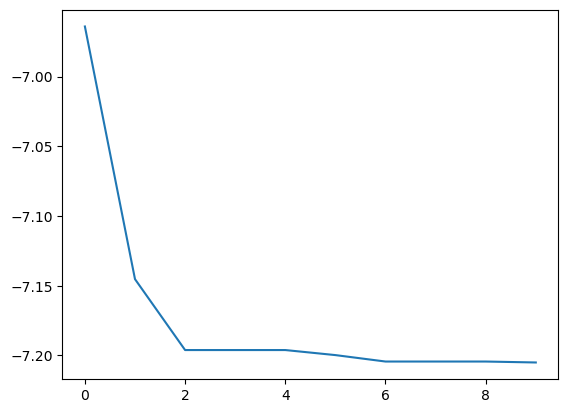

In [226]:
import matplotlib.pyplot as plt

plt.plot(gbest_y_hist)
plt.show()

# search PSO hyperparameters

In [12]:
import numpy as np
import torch
from functools import partial

class CustomPSO:
    def __init__(self, func, n_dim, pop=40, max_iter=150, lb=-1e5, ub=1e5, w=0.8, c1=0.5, c2=0.5, initial_guess=None):
        self.func = func
        self.n_dim = n_dim
        self.pop = pop
        self.max_iter = max_iter
        self.lb = torch.tensor(lb * np.ones(self.n_dim), device='cuda:0', dtype=torch.float32)
        self.ub = torch.tensor(ub * np.ones(self.n_dim), device='cuda:0', dtype=torch.float32)
        self.w = w
        self.c1 = c1
        self.c2 = c2

        assert self.n_dim == len(self.lb) == len(self.ub), 'dim == len(lb) == len(ub) is not True'
        assert torch.all(self.ub > self.lb), 'upper-bound must be greater than lower-bound'

        # Initialize particles' positions
        self.X = torch.rand((self.pop, self.n_dim), device='cuda:0') * (self.ub - self.lb) + self.lb
        if initial_guess is not None:
            self.X[0] = initial_guess  # Set the first particle to the initial guess
            # print("Initial guess set for the first particle:", self.X[0].cpu().numpy())  # Debug statement

        # Initialize particles' velocities
        v_high = self.ub - self.lb
        self.V = torch.rand((self.pop, self.n_dim), device='cuda:0') * 2 * v_high - v_high

        # Evaluate initial fitness
        self.Y = torch.tensor([self.func(x) for x in self.X], device='cuda:0', dtype=torch.float32).reshape(-1, 1)

        # Initialize personal best positions and values
        self.pbest_x = self.X.clone()
        self.pbest_y = self.Y.clone()

        # Initialize global best position and value
        self.gbest_x = self.pbest_x[self.pbest_y.argmin()].clone()
        self.gbest_y = self.pbest_y.min()
        self.gbest_y_hist = []

    def update_V(self):
        r1 = torch.rand((self.pop, self.n_dim), device='cuda:0')
        r2 = torch.rand((self.pop, self.n_dim), device='cuda:0')
        self.V = self.w * self.V + \
                 self.c1 * r1 * (self.pbest_x - self.X) + \
                 self.c2 * r2 * (self.gbest_x - self.X)

    def update_X(self):
        self.X = self.X + self.V
        self.X = torch.max(torch.min(self.X, self.ub), self.lb)

    def cal_y(self):
        self.Y = torch.tensor([self.func(x) for x in self.X], device='cuda:0', dtype=torch.float32).reshape(-1, 1)
        return self.Y

    def update_pbest(self):
        mask = self.Y < self.pbest_y
        self.pbest_x = torch.where(mask, self.X, self.pbest_x)
        self.pbest_y = torch.where(mask, self.Y, self.pbest_y)

    def update_gbest(self):
        idx_min = self.pbest_y.argmin()
        if self.gbest_y > self.pbest_y[idx_min]:
            self.gbest_x = self.pbest_x[idx_min].clone()
            self.gbest_y = self.pbest_y[idx_min]

    def run(self):
        for iter_num in range(self.max_iter):
            self.update_V()
            self.update_X()
            self.cal_y()
            self.update_pbest()
            self.update_gbest()

            self.gbest_y_hist.append(self.gbest_y.item())
            if iter_num % 50 == 0:
                #print(f'Iter: {iter_num}, Best fit: {self.gbest_y.item()} at {self.gbest_x.cpu().numpy()}')
                
                print(f'Iter: {iter_num}, Best fit: {self.gbest_y.item()}')

        return self.gbest_x, self.gbest_y

def calculate_energy(spins, data, pretrained_model):
    num_particles, num_params = spins.shape
    num_spins = num_params // 2
    magnitudes = spins[:, :num_spins]
    directions = spins[:, num_spins:]
    spins_magnitude = magnitudes
    directions = directions
    directions = torch.round(directions)
    directions = torch.clamp(directions, -1, 1)
    spin_vectors = torch.stack([torch.zeros_like(directions), torch.zeros_like(directions), directions], dim=2)

    """Calculate the total energy of the spin system"""
    data.natoms = torch.tensor([68], device='cuda:0')
    n_neighbors = []
    n_index = data.edge_index[1, :]
    n_neighbors.append(n_index.shape[0])
    data.neighbors = torch.tensor(n_neighbors, device='cuda:0')
    # update spin direction and spins_magnitude: try 1 don't change direction of spin, and change direction of spin
    data.inmag = spins_magnitude[0]
    data.magft = spin_vectors[0]

    energy_preds, magmom_preds = pretrained_model(data.to("cuda:0"))

    return energy_preds.item()  # Assuming energy_preds is a tensor of shape (1,)

def fitness(flat_spins, data, pretrained_model, num_atoms):
    num_particles = flat_spins.size(0) // (2 * num_atoms)
    spins = flat_spins.view(num_particles, 2 * num_atoms)
    return calculate_energy(spins, data, pretrained_model)

def pso_spin_optimization(data, pretrained_model, initial_guess=None, num_atoms=68, num_particles=30, num_iterations=100, w=0.8, c1=1.5, c2=1.5):
    num_params = 2 * num_atoms
    lb = [-20] * num_atoms + [-1] * num_atoms  # [-8, 8] is the boundary for magnitude, [-1, 1] is the boundary for vector
    ub = [20] * num_atoms + [1] * num_atoms

    # Create the fitness function with frozen data and pretrained_model
    fitness_with_params = partial(fitness, data=data, pretrained_model=pretrained_model, num_atoms=num_atoms)

    # Create the CustomPSO instance
    pso = CustomPSO(func=fitness_with_params, 
                    n_dim=num_params, 
                    pop=num_particles, 
                    max_iter=num_iterations, 
                    lb=lb, 
                    ub=ub, 
                    w=w, 
                    c1=c1, 
                    c2=c2,
                    initial_guess=initial_guess)

    # # Verify initial guess is set correctly
    # print("Initial guess in optimization function:", initial_guess.cpu().numpy())  # Debug statement
    # print("Initial positions in PSO before run:", pso.X.cpu().numpy())  # Debug statement

    # Run the PSO optimization
    best_x, best_y = pso.run()

    best_positions = best_x.view(num_atoms, 2).cpu().numpy()
    best_energy = best_y.item()

    return best_positions, best_energy, pso.gbest_y_hist



#params = {'c1': 2.0, 'c2': 1.0, 'num_iterations': 1000, 'num_particles': 20, 'w': 0.7}


#params = {'c1': 2.0, 'c2': 1.0, 'num_iterations': 1000, 'num_particles': 50, 'w': 0.7}

params = {'c1': 2.0, 'c2': 2.0, 'num_iterations': 5000, 'num_particles': 30, 'w': 0.2}

# Example usage
data = torch.load("/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_paper/chgnet_Elabel_applications/surface/processed/data_6.pt").to("cuda:0")
checkpoint = "/pscratch/sd/w/wenxu/jobs/OCP/github_rep/ocp_mag_chgnet_new/magmom_checkpoints/right/Large_schnet_Einmag_all_application_91split_withoutoverlap-epoch=456-step=228043-val_loss=0.0257.ckpt"
pretrained_model = MagmomClassifier.load_from_checkpoint(checkpoint_path=checkpoint,
                                                         backbone=schnet_onehot_inmag)

initial_magnitudes = data.inmag.cpu().flatten()
initial_directions = data.magft[:, 2].cpu().flatten()

initial_guess = torch.cat((initial_magnitudes, initial_directions)).to("cuda:0")

best_positions, best_energy, energy_history = pso_spin_optimization(data=data, 
                                                                    pretrained_model=pretrained_model,
                                                                    initial_guess=initial_guess, 
                                                                    **params)
# print("Best Spin Configuration (Magnitude, Direction):", best_positions)
# print("Best Energy:", best_energy)

Iter: 0, Best fit: -7.244770526885986
Iter: 50, Best fit: -7.3172197341918945
Iter: 100, Best fit: -7.3336076736450195
Iter: 150, Best fit: -7.341277122497559
Iter: 200, Best fit: -7.345366477966309
Iter: 250, Best fit: -7.3496809005737305
Iter: 300, Best fit: -7.354484558105469
Iter: 350, Best fit: -7.355637073516846
Iter: 400, Best fit: -7.356513023376465
Iter: 450, Best fit: -7.35679292678833
Iter: 500, Best fit: -7.356967926025391
Iter: 550, Best fit: -7.357541084289551
Iter: 600, Best fit: -7.35764741897583
Iter: 650, Best fit: -7.357667922973633
Iter: 700, Best fit: -7.357690811157227
Iter: 750, Best fit: -7.35833215713501
Iter: 800, Best fit: -7.358905792236328
Iter: 850, Best fit: -7.359270095825195
Iter: 900, Best fit: -7.35933780670166
Iter: 950, Best fit: -7.360561847686768
Iter: 1000, Best fit: -7.360581398010254
Iter: 1050, Best fit: -7.360598564147949
Iter: 1100, Best fit: -7.360646724700928
Iter: 1150, Best fit: -7.360647678375244
Iter: 1200, Best fit: -7.360659599304199